In [ ]:
%pip install prettytable
%pip install prettyplotlib
%pip install -U matplotlib==3.2

In [2]:
# Get Hyptrails and Pathtools from https://github.com/psinger/HypTrails

from prettytable import PrettyTable
import pandas as pd
import os

In [3]:
os.chdir("/home/jovyan/hyptrailsreco/src")

In [4]:
from hyptrails.hyptrails import *
from hyptrails.trial_roulette import *
from pathtools.markovchain import *
from pathtools.markovtools import *
from scipy.sparse import lil_matrix, csr_matrix

In [19]:
fig_name = "coveo"
cat_id = "category_product_id:token"
cat = "category_hash:token_seq"
list_name= "SEARCHLIST"
item_id = 'product_sku_hash:token'
session_id ='session_id_hash:token'
interactions_path = "/home/jovyan/datasets/plp-paper-recbole/coveo-sl-search-colfix/coveo-sl-search-recbole/coveo-sl-search-recbole.train.inter"

In [43]:
fig_name = "ml-20m-extended"
cat_id = "title_genres:token"
cat = "genres:token_seq"
list_name= "OVERVIEW"
item_id = 'title:token'
session_id ='userId:token'
interactions_path = "/home/jovyan/datasets/plp-paper-recbole/ml-20m-extended/ml-20m-extended-recbole/ml-20m-extended-recbole.train.inter"

In [44]:
interaction_df = pd.read_csv(interactions_path, sep = "\t")

In [45]:
#interaction_df =interaction_df.head(1000)

In [47]:
interaction_df["states"] = interaction_df.apply(
    lambda row: f"{row[item_id]} + {row[cat_id]}" if row[item_id] == list_name else row[cat], axis=1)

In [48]:
interaction_df.head()

,timestamp:float,item_id_type:float,userId:token,title:token,title_genres:token,genres:token_seq,states
0,974820598,0,2,OVERVIEW-PAGE,Drama,Drama,Drama
1,974820598,1,2,Mr. Holland's Opus (1995),Mr. Holland's Opus (1995),Drama,Drama
2,974820598,0,2,OVERVIEW-PAGE,Drama|Romance,Drama|Romance,Drama|Romance
3,974820598,1,2,"House of the Spirits, The (1993)","House of the Spirits, The (1993)",Drama|Romance,Drama|Romance
4,974820598,0,2,OVERVIEW-PAGE,Drama,Drama,Drama


In [49]:
#Build vocabulary/state
vocab = {page: idx for idx, page in enumerate(interaction_df["states"].unique())}
reduced_df = interaction_df[["states", cat]].drop_duplicates()
overview_genres = interaction_df[interaction_df[item_id] == list_name]["states"].unique()
user_transitions = interaction_df.groupby(session_id)["states"].apply(list).tolist()

states_dict = dict(zip(reduced_df['states'], reduced_df[cat]))
user_transitions = interaction_df.groupby(session_id)['states'].apply(list).tolist()

In [50]:
def data_prior(paths, vocab, k, ax):
    shape_matrix = (max(vocab.values()) + 1, max(vocab.values()) + 1)
    evidences = {}
    shape = len(vocab)
    for i in k:
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)
        else:
            # We first calculate the MLE for the data
            markov = MarkovChain(k=1, use_prior=False, reset = False, modus="mle")
            markov.prepare_data(paths)
            markov.fit(paths)
            mle = markov.transition_dict_norm_
            
            # Now we use the parameter configuration from the MLE as a hypothesis
            i_indices = list()
            j_indices = list()
            values = list()
            for s,targets in mle.items():
                for t, v in targets.items():
                    i_indices.append(vocab[s[0]])
                    j_indices.append(vocab[t])
                    values.append(v)

            matrix_data = csr_matrix((values, (i_indices, j_indices)),
                             shape=shape_matrix, dtype=np.float64)
            chips = i*(matrix_data.shape[0]-1.)
            prior = distr_chips_row(matrix_data, chips, n_jobs=1)

        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                                specific_prior_vocab = vocab, state_count=len(vocab), modus="bayes")
        markov.prepare_data(paths)
        markov.fit(paths)

        evidence = markov.bayesian_evidence()
        evidences[i] = evidence

    ax.plot(list(evidences.keys()), list(evidences.values()), marker='o', clip_on = False, label="data", linestyle='--')
    return evidences

In [51]:
def uniform_prior(paths, vocab, k, ax):
    shape = len(vocab)
    evidences = {}
    for i in k:
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)
        else:
            matrix_uniform = lil_matrix((shape,shape), dtype=np.float64)
            matrix_uniform[:] = 1.
            #matrix_uniform.setdiag(0.)
            matrix_uniform = matrix_uniform.tocsr()

            chips = i*(matrix_uniform.shape[0]-1.)
            prior = distr_chips_row(matrix_uniform, chips, n_jobs=1)
        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1.+i, specific_prior=prior,
                                specific_prior_vocab = vocab, modus="bayes")
        
        markov.prepare_data(paths)
        markov.fit(paths)
        evidence = markov.bayesian_evidence()
        evidences[i] = evidence

    ax.plot(list(evidences.keys()), list(evidences.values()), marker='o', clip_on = False, label="uniform", linestyle='-.')
    return evidences
    

In [52]:
from sklearn.preprocessing import normalize
def struc_prior(paths, vocab, k, ax):
    i_indices = list()
    j_indices = list()
    values = list()
    # Let us iterate through all nodes
    for s,v in states_dict.items():
        overview_id = vocab[s]
        for s2,v2 in states_dict.items():
            if v2 == v:
                node_id = vocab[s2]
                i_indices.append(overview_id)
                j_indices.append(node_id)
                values.append(1)

    shape_matrix = (max(vocab.values()) + 1, max(vocab.values()) + 1)
    evidences = {}
    shape = len(vocab)
    for i in k:
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)
        else:
            # Creating the matrix with above defined values
            matrix_struc = csr_matrix((values, (i_indices, j_indices)),
                             shape=shape_matrix, dtype=np.float64)

            chips = i*(matrix_struc.shape[0]-1.)
            prior = distr_chips_row(matrix_struc, chips, n_jobs=1)
        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                                specific_prior_vocab = vocab, state_count=len(vocab), modus="bayes")
        markov.prepare_data(paths)
        markov.fit(paths)
        evidence = markov.bayesian_evidence()
        evidences[i] = evidence
    
    ax.plot(list(evidences.keys()), list(evidences.values()), marker='o', clip_on = False, label="structural", linestyle='--')
    return evidences

In [53]:
def uni_struct_prior(paths, vocab, k, ax):

    i_indices = list()
    j_indices = list()
    values = list()
    # Let us iterate through all nodes
    for s,v in states_dict.items():
        overview_id = vocab[s]
        for s2,v2 in states_dict.items():
            if v2 == v:
                node_id = vocab[s2]
                i_indices.append(overview_id)
                j_indices.append(node_id)
                values.append(1)

    shape_matrix = (max(vocab.values()) + 1, max(vocab.values()) + 1)

    
    shape = len(vocab)
    evidences = {}
    for i in k:
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)
        else:
            matrix_struc = csr_matrix((values, (i_indices, j_indices)),
                 shape=shape_matrix, dtype=np.float64)
            matrix_uniform = lil_matrix((shape,shape), dtype=np.float64)
            matrix_uniform[:] = 1.
            matrix_uniform = matrix_uniform+matrix_struc
            #matrix_uniform.setdiag(0.)
            matrix_uniform = matrix_uniform.tocsr()

            chips = i*(matrix_uniform.shape[0]-1.)
            prior = distr_chips_row(matrix_uniform, chips, n_jobs=1)
        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1.+i, specific_prior=prior,
                                specific_prior_vocab = vocab, modus="bayes")
        
        markov.prepare_data(paths)
        markov.fit(paths)
        evidence = markov.bayesian_evidence()
        evidences[i] = evidence

    ax.plot(list(evidences.keys()), list(evidences.values()), marker='o', clip_on = False, label="uniform+structural", linestyle='--')
    return evidences
    

!
!
!
!


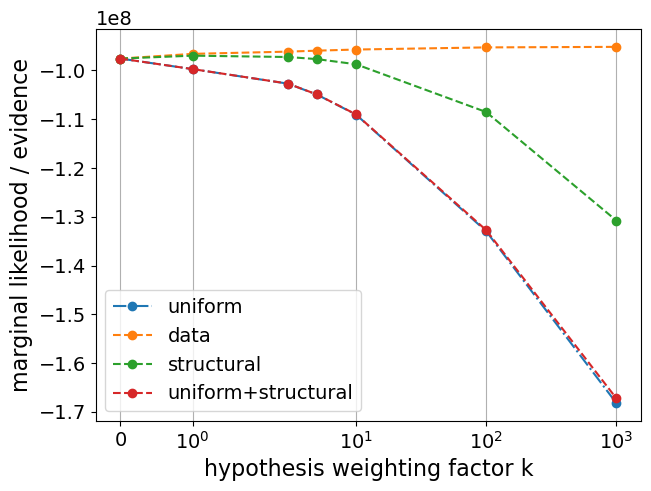

In [54]:
fig = plt.figure()


plt.rc('font', size=16)  # default text size
plt.rc('axes', titlesize=25)  # axes title size
plt.rc('axes', labelsize=16)  # x and y label size
plt.rc('xtick', labelsize=14)  # x tick label size
plt.rc('ytick', labelsize=14)  # y tick label size
plt.rc('legend', fontsize=14)  # legend font size
plt.rc('figure', titlesize=20)  # figure title size

k= [0,1,3,5,10,100, 1000]
paths= user_transitions
ax = fig.add_subplot(111)
ax.set_xscale("symlog")

# Now, let us calculate the evidences
ret = uniform_prior(paths, vocab, k, ax)
print("Uniform done")
ret = data_prior(paths, vocab, k, ax)
print("data done")
ret = struc_prior(paths, vocab, k, ax)
print("struc done")
ret = uni_struct_prior(paths, vocab, k, ax)
print("mixture done")

# Further plotting
ax.set_xlabel("hypothesis weighting factor k")
ax.set_ylabel("marginal likelihood / evidence")

plt.legend()
plt.grid(False)
ax.xaxis.grid(True)
plt.tight_layout(pad=0.2)
#lt.savefig('/home/jovyan/plp-paper/hyptrails-'+fig_name+'.png', format='png', dpi=300, bbox_inches='tight')
plt.show()